In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Connect with drive data

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
# uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
#downloaded = drive.CreateFile({'id': '10YHxlCWl8YlHszTFuGVLHEbiVy3qYDX1'})

file = drive.CreateFile({'id': '10YHxlCWl8YlHszTFuGVLHEbiVy3qYDX1'})
file.GetContentFile('fer2013.csv')

### Code for downloading files

In [0]:
from google.colab import files

# with open('example.txt', 'w') as f:
#   f.write('some content')

# files.download('example.txt')

# files.download('fer2013.csv')

In [4]:
!ls

datalab  fer2013.csv


### Load data

In [0]:
data = pd.read_csv('fer2013.csv')

In [14]:
data.shape

(35887, 3)

In [15]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Test an image

In [0]:
np_data = np.array(data)

In [17]:
np_data.shape

(35887, 3)

In [18]:
np_data[0]

array([0,
       '70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197

In [19]:
test_image = np_data[0][1].split(" ")
print(type(test_image))
print(len(test_image))

<class 'list'>
2304


In [20]:
48*48

2304

In [21]:
test_image = np.array(test_image).reshape(48, 48)
test_image.shape

(48, 48)

In [0]:
test_image = test_image.astype('float')

In [23]:
test_image

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]])

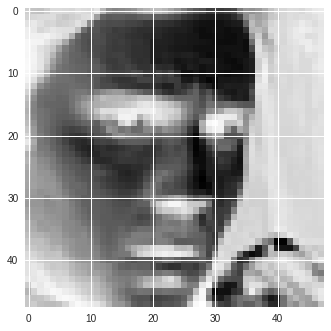

In [24]:
plt.imshow(test_image)

# Data preprocessing

In [0]:
import scipy.misc
import os

for i in range(len(data)):
  directory = 'data/'+np_data[i][2]+'/'+str(np_data[i][0])
  if not os.path.exists(directory):
    os.makedirs(directory)
    
  test_image = np_data[i][1].split(" ")
  test_image = np.array(test_image).reshape(48, 48)
  test_image = test_image.astype('float')

  scipy.misc.imsave(directory+'/'+str(i)+'.jpg', test_image)

In [64]:
!ls data/


PrivateTest  PublicTest  Training


# Training with CNN

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical

from keras import models
from keras import layers

from keras import losses, optimizers, metrics


In [79]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = 'data/Training'
validation_dir = 'data/PublicTest'
test_dir ='data/PrivateTest'


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size=32
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (48, 48),
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [71]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               524416    
__________

In [72]:
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy']
             )

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 900,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=115
)

Epoch 1/30
900/900 [==============================] - 17s 18ms/step - loss: 1.5787 - acc: 0.3835 - val_loss: 1.4068 - val_acc: 0.4572
Epoch 2/30
900/900 [==============================] - 15s 17ms/step - loss: 1.3183 - acc: 0.4996 - val_loss: 1.2876 - val_acc: 0.5149
Epoch 3/30
264/900 [=======>......................] - ETA: 9s - loss: 1.2117 - acc: 0.5445

900/900 [==============================] - 15s 17ms/step - loss: 1.1938 - acc: 0.5501 - val_loss: 1.2367 - val_acc: 0.5292
Epoch 4/30
900/900 [==============================] - 15s 17ms/step - loss: 1.0935 - acc: 0.5918 - val_loss: 1.2476 - val_acc: 0.5226
Epoch 5/30
388/900 [===========>..................] - ETA: 7s - loss: 0.9903 - acc: 0.6361

900/900 [==============================] - 15s 17ms/step - loss: 0.9971 - acc: 0.6309 - val_loss: 1.2305 - val_acc: 0.5439
Epoch 6/30
900/900 [==============================] - 15s 17ms/step - loss: 0.8874 - acc: 0.6737 - val_loss: 1.3460 - val_acc: 0.5393
Epoch 7/30
416/900 [============>.................] - ETA: 7s - loss: 0.7620 - acc: 0.7212

900/900 [==============================] - 15s 17ms/step - loss: 0.7813 - acc: 0.7157 - val_loss: 1.4082 - val_acc: 0.5494
Epoch 8/30
900/900 [==============================] - 15s 17ms/step - loss: 0.6711 - acc: 0.7595 - val_loss: 1.5336 - val_acc: 0.5439
Epoch 9/30
421/900 [=============>................] - ETA: 7s - loss: 0.5419 - acc: 0.8036

900/900 [==============================] - 15s 17ms/step - loss: 0.5630 - acc: 0.7973 - val_loss: 1.6756 - val_acc: 0.5601
Epoch 10/30
900/900 [==============================] - 15s 17ms/step - loss: 0.4688 - acc: 0.8350 - val_loss: 1.9576 - val_acc: 0.5620
Epoch 11/30
436/900 [=============>................] - ETA: 6s - loss: 0.3628 - acc: 0.8730

900/900 [==============================] - 15s 16ms/step - loss: 0.3876 - acc: 0.8645 - val_loss: 2.1413 - val_acc: 0.5330
Epoch 12/30
900/900 [==============================] - 15s 17ms/step - loss: 0.3170 - acc: 0.8889 - val_loss: 2.2874 - val_acc: 0.5552
Epoch 13/30
437/900 [=============>................] - ETA: 7s - loss: 0.2379 - acc: 0.9167

900/900 [==============================] - 15s 16ms/step - loss: 0.2619 - acc: 0.9086 - val_loss: 2.7009 - val_acc: 0.5601
Epoch 14/30
900/900 [==============================] - 15s 17ms/step - loss: 0.2244 - acc: 0.9225 - val_loss: 2.7540 - val_acc: 0.5300
Epoch 15/30
434/900 [=============>................] - ETA: 7s - loss: 0.1770 - acc: 0.9412

900/900 [==============================] - 15s 17ms/step - loss: 0.1932 - acc: 0.9351 - val_loss: 3.1151 - val_acc: 0.5185
Epoch 16/30
900/900 [==============================] - 15s 17ms/step - loss: 0.1710 - acc: 0.9431 - val_loss: 3.2083 - val_acc: 0.5483
Epoch 17/30
425/900 [=============>................] - ETA: 7s - loss: 0.1490 - acc: 0.9499

900/900 [==============================] - 15s 17ms/step - loss: 0.1576 - acc: 0.9480 - val_loss: 3.5193 - val_acc: 0.5396
Epoch 18/30
900/900 [==============================] - 15s 17ms/step - loss: 0.1502 - acc: 0.9512 - val_loss: 3.3493 - val_acc: 0.5311
Epoch 19/30
408/900 [============>.................] - ETA: 7s - loss: 0.1311 - acc: 0.9575

900/900 [==============================] - 15s 17ms/step - loss: 0.1394 - acc: 0.9549 - val_loss: 3.9319 - val_acc: 0.5469
Epoch 20/30
900/900 [==============================] - 15s 17ms/step - loss: 0.1434 - acc: 0.9562 - val_loss: 3.6453 - val_acc: 0.5582
Epoch 21/30
382/900 [===========>..................] - ETA: 8s - loss: 0.1114 - acc: 0.9638

900/900 [==============================] - 16s 18ms/step - loss: 0.1291 - acc: 0.9609 - val_loss: 3.7181 - val_acc: 0.5105
Epoch 22/30
900/900 [==============================] - 16s 18ms/step - loss: 0.1233 - acc: 0.9634 - val_loss: 3.7844 - val_acc: 0.5374
Epoch 23/30
357/900 [==========>...................] - ETA: 8s - loss: 0.1022 - acc: 0.9689

900/900 [==============================] - 16s 17ms/step - loss: 0.1193 - acc: 0.9635 - val_loss: 4.0233 - val_acc: 0.5393
Epoch 24/30
900/900 [==============================] - 16s 17ms/step - loss: 0.1226 - acc: 0.9635 - val_loss: 3.9205 - val_acc: 0.5264
Epoch 25/30
347/900 [==========>...................] - ETA: 8s - loss: 0.1064 - acc: 0.9694

900/900 [==============================] - 16s 17ms/step - loss: 0.1186 - acc: 0.9660 - val_loss: 3.9244 - val_acc: 0.5073
Epoch 26/30
900/900 [==============================] - 16s 17ms/step - loss: 0.1235 - acc: 0.9650 - val_loss: 4.3725 - val_acc: 0.5179
Epoch 27/30
349/900 [==========>...................] - ETA: 8s - loss: 0.1014 - acc: 0.9695

900/900 [==============================] - 15s 17ms/step - loss: 0.1173 - acc: 0.9662 - val_loss: 4.2262 - val_acc: 0.5412
Epoch 28/30
900/900 [==============================] - 15s 17ms/step - loss: 0.1157 - acc: 0.9666 - val_loss: 4.4262 - val_acc: 0.5374
Epoch 29/30
372/900 [===========>..................] - ETA: 8s - loss: 0.0959 - acc: 0.9715

900/900 [==============================] - 15s 17ms/step - loss: 0.1074 - acc: 0.9679 - val_loss: 4.2263 - val_acc: 0.5086
Epoch 30/30
900/900 [==============================] - 16s 17ms/step - loss: 0.1136 - acc: 0.9681 - val_loss: 4.0870 - val_acc: 0.5363


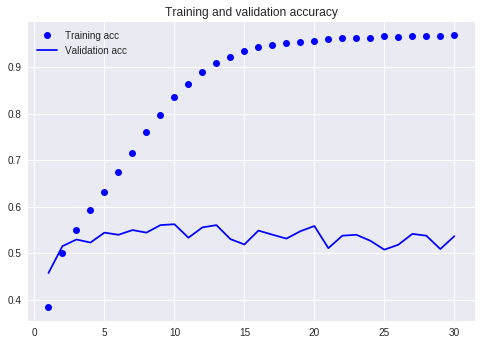

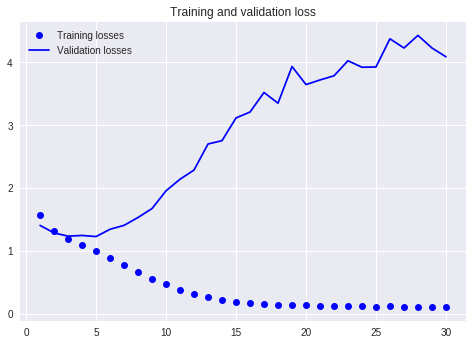

In [73]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Try using pretrined model

In [74]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(48, 48, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [75]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 3591      
Total params: 14,980,935
Trainable params: 14,980,935
Non-trainable params: 0
_________________________________________________________________


In [80]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=900, 
                              epochs=15, 
                              validation_data=validation_generator, 
                              validation_steps=115)

900/900 [==============================] - 32s 36ms/step - loss: 1.4521 - categorical_accuracy: 0.4476 - val_loss: 1.5187 - val_categorical_accuracy: 0.4218
Epoch 8/15
501/900 [===============>..............] - ETA: 12s - loss: 1.4390 - categorical_accuracy: 0.4523

900/900 [==============================] - 32s 35ms/step - loss: 1.4397 - categorical_accuracy: 0.4528 - val_loss: 1.4941 - val_categorical_accuracy: 0.4260
Epoch 9/15
602/900 [===================>..........] - ETA: 9s - loss: 1.4304 - categorical_accuracy: 0.4571

900/900 [==============================] - 32s 36ms/step - loss: 1.4285 - categorical_accuracy: 0.4573 - val_loss: 1.4996 - val_categorical_accuracy: 0.4243
Epoch 10/15
633/900 [====================>.........] - ETA: 8s - loss: 1.4168 - categorical_accuracy: 0.4624

900/900 [==============================] - 32s 35ms/step - loss: 1.4205 - categorical_accuracy: 0.4617 - val_loss: 1.4803 - val_categorical_accuracy: 0.4353
Epoch 11/15
642/900 [====================>.........] - ETA: 8s - loss: 1.4102 - categorical_accuracy: 0.4639

900/900 [==============================] - 32s 36ms/step - loss: 1.4074 - categorical_accuracy: 0.4657 - val_loss: 1.5057 - val_categorical_accuracy: 0.4254
Epoch 12/15
649/900 [====================>.........] - ETA: 8s - loss: 1.3995 - categorical_accuracy: 0.4713

900/900 [==============================] - 32s 36ms/step - loss: 1.4002 - categorical_accuracy: 0.4705 - val_loss: 1.4783 - val_categorical_accuracy: 0.4358
Epoch 13/15
649/900 [====================>.........] - ETA: 7s - loss: 1.3896 - categorical_accuracy: 0.4775

900/900 [==============================] - 32s 35ms/step - loss: 1.3879 - categorical_accuracy: 0.4764 - val_loss: 1.5046 - val_categorical_accuracy: 0.4227
Epoch 14/15
653/900 [====================>.........] - ETA: 7s - loss: 1.3767 - categorical_accuracy: 0.4824

900/900 [==============================] - 32s 36ms/step - loss: 1.3786 - categorical_accuracy: 0.4804 - val_loss: 1.4999 - val_categorical_accuracy: 0.4342
Epoch 15/15
652/900 [====================>.........] - ETA: 7s - loss: 1.3725 - categorical_accuracy: 0.4852

900/900 [==============================] - 32s 36ms/step - loss: 1.3715 - categorical_accuracy: 0.4855 - val_loss: 1.4598 - val_categorical_accuracy: 0.4531


In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=900, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=115)

Epoch 1/30
900/900 [==============================] - 48s 53ms/step - loss: 1.4918 - categorical_accuracy: 0.4282 - val_loss: 1.3534 - val_categorical_accuracy: 0.4771
Epoch 2/30
224/900 [======>.......................] - ETA: 32s - loss: 1.2861 - categorical_accuracy: 0.5146

900/900 [==============================] - 47s 52ms/step - loss: 1.2804 - categorical_accuracy: 0.5169 - val_loss: 1.3517 - val_categorical_accuracy: 0.5004
Epoch 3/30
357/900 [==========>...................] - ETA: 26s - loss: 1.1627 - categorical_accuracy: 0.5629

900/900 [==============================] - 47s 52ms/step - loss: 1.1609 - categorical_accuracy: 0.5660 - val_loss: 1.3228 - val_categorical_accuracy: 0.5111
Epoch 4/30
384/900 [===========>..................] - ETA: 25s - loss: 1.0394 - categorical_accuracy: 0.6144

900/900 [==============================] - 47s 52ms/step - loss: 1.0462 - categorical_accuracy: 0.6115 - val_loss: 1.2752 - val_categorical_accuracy: 0.5494
Epoch 5/30
384/900 [===========>..................] - ETA: 25s - loss: 0.9212 - categorical_accuracy: 0.6572

900/900 [==============================] - 47s 53ms/step - loss: 0.9340 - categorical_accuracy: 0.6557 - val_loss: 1.2872 - val_categorical_accuracy: 0.5604
Epoch 6/30
384/900 [===========>..................] - ETA: 25s - loss: 0.8030 - categorical_accuracy: 0.7043

900/900 [==============================] - 47s 52ms/step - loss: 0.8191 - categorical_accuracy: 0.7010 - val_loss: 1.4406 - val_categorical_accuracy: 0.5634
Epoch 7/30
417/900 [============>.................] - ETA: 23s - loss: 0.6940 - categorical_accuracy: 0.7496

900/900 [==============================] - 47s 52ms/step - loss: 0.7098 - categorical_accuracy: 0.7449 - val_loss: 1.5557 - val_categorical_accuracy: 0.5705
Epoch 8/30
407/900 [============>.................] - ETA: 24s - loss: 0.5906 - categorical_accuracy: 0.7892

900/900 [==============================] - 47s 52ms/step - loss: 0.6080 - categorical_accuracy: 0.7832 - val_loss: 1.5862 - val_categorical_accuracy: 0.5905
Epoch 9/30
410/900 [============>.................] - ETA: 23s - loss: 0.5025 - categorical_accuracy: 0.8231

900/900 [==============================] - 47s 52ms/step - loss: 0.5210 - categorical_accuracy: 0.8158 - val_loss: 1.9365 - val_categorical_accuracy: 0.5535
Epoch 10/30
408/900 [============>.................] - ETA: 24s - loss: 0.4372 - categorical_accuracy: 0.8486

900/900 [==============================] - 47s 52ms/step - loss: 0.4438 - categorical_accuracy: 0.8446 - val_loss: 1.9239 - val_categorical_accuracy: 0.5812
Epoch 11/30
400/900 [============>.................] - ETA: 24s - loss: 0.3646 - categorical_accuracy: 0.8745

900/900 [==============================] - 47s 52ms/step - loss: 0.3754 - categorical_accuracy: 0.8700 - val_loss: 2.0079 - val_categorical_accuracy: 0.5598
Epoch 12/30
398/900 [============>.................] - ETA: 24s - loss: 0.3148 - categorical_accuracy: 0.8931

900/900 [==============================] - 47s 52ms/step - loss: 0.3332 - categorical_accuracy: 0.8863 - val_loss: 2.1530 - val_categorical_accuracy: 0.5661
Epoch 13/30
402/900 [============>.................] - ETA: 24s - loss: 0.2803 - categorical_accuracy: 0.9077

900/900 [==============================] - 47s 52ms/step - loss: 0.2906 - categorical_accuracy: 0.9043 - val_loss: 2.0975 - val_categorical_accuracy: 0.5669
Epoch 14/30
439/900 [=============>................] - ETA: 22s - loss: 0.2510 - categorical_accuracy: 0.9181

900/900 [==============================] - 47s 52ms/step - loss: 0.2575 - categorical_accuracy: 0.9144 - val_loss: 2.5854 - val_categorical_accuracy: 0.5494
Epoch 15/30
393/900 [============>.................] - ETA: 24s - loss: 0.2216 - categorical_accuracy: 0.9264

900/900 [==============================] - 47s 52ms/step - loss: 0.2351 - categorical_accuracy: 0.9230 - val_loss: 2.3545 - val_categorical_accuracy: 0.5866
Epoch 16/30
401/900 [============>.................] - ETA: 24s - loss: 0.2080 - categorical_accuracy: 0.9377

900/900 [==============================] - 47s 52ms/step - loss: 0.2229 - categorical_accuracy: 0.9320 - val_loss: 2.3921 - val_categorical_accuracy: 0.5738
Epoch 17/30
410/900 [============>.................] - ETA: 23s - loss: 0.1914 - categorical_accuracy: 0.9414

900/900 [==============================] - 47s 52ms/step - loss: 0.1996 - categorical_accuracy: 0.9375 - val_loss: 2.5038 - val_categorical_accuracy: 0.5795
Epoch 18/30
408/900 [============>.................] - ETA: 23s - loss: 0.1720 - categorical_accuracy: 0.9451

900/900 [==============================] - 47s 52ms/step - loss: 0.1856 - categorical_accuracy: 0.9416 - val_loss: 2.9242 - val_categorical_accuracy: 0.5792
Epoch 19/30
402/900 [============>.................] - ETA: 24s - loss: 0.1658 - categorical_accuracy: 0.9479

900/900 [==============================] - 47s 52ms/step - loss: 0.1815 - categorical_accuracy: 0.9442 - val_loss: 2.5022 - val_categorical_accuracy: 0.5773
Epoch 20/30
397/900 [============>.................] - ETA: 24s - loss: 0.1578 - categorical_accuracy: 0.9532

900/900 [==============================] - 47s 52ms/step - loss: 0.1623 - categorical_accuracy: 0.9512 - val_loss: 2.9038 - val_categorical_accuracy: 0.5615
Epoch 21/30
386/900 [===========>..................] - ETA: 25s - loss: 0.1596 - categorical_accuracy: 0.9542

900/900 [==============================] - 47s 53ms/step - loss: 0.1667 - categorical_accuracy: 0.9514 - val_loss: 2.5588 - val_categorical_accuracy: 0.5803
Epoch 22/30
388/900 [===========>..................] - ETA: 24s - loss: 0.1504 - categorical_accuracy: 0.9558

900/900 [==============================] - 47s 52ms/step - loss: 0.1556 - categorical_accuracy: 0.9550 - val_loss: 3.3136 - val_categorical_accuracy: 0.5806
Epoch 23/30
405/900 [============>.................] - ETA: 24s - loss: 0.1486 - categorical_accuracy: 0.9585

900/900 [==============================] - 47s 52ms/step - loss: 0.1493 - categorical_accuracy: 0.9575 - val_loss: 3.1114 - val_categorical_accuracy: 0.5823
Epoch 24/30
393/900 [============>.................] - ETA: 24s - loss: 0.1387 - categorical_accuracy: 0.9573

900/900 [==============================] - 47s 53ms/step - loss: 0.1500 - categorical_accuracy: 0.9567 - val_loss: 3.3501 - val_categorical_accuracy: 0.5453
Epoch 25/30
381/900 [===========>..................] - ETA: 25s - loss: 0.1378 - categorical_accuracy: 0.9595

900/900 [==============================] - 47s 53ms/step - loss: 0.1463 - categorical_accuracy: 0.9589 - val_loss: 2.7498 - val_categorical_accuracy: 0.5628
Epoch 26/30
384/900 [===========>..................] - ETA: 25s - loss: 0.1314 - categorical_accuracy: 0.9635

900/900 [==============================] - 47s 53ms/step - loss: 0.1407 - categorical_accuracy: 0.9616 - val_loss: 3.2889 - val_categorical_accuracy: 0.5407
Epoch 27/30
392/900 [============>.................] - ETA: 24s - loss: 0.1267 - categorical_accuracy: 0.9651

900/900 [==============================] - 47s 53ms/step - loss: 0.1351 - categorical_accuracy: 0.9623 - val_loss: 2.9968 - val_categorical_accuracy: 0.5864
Epoch 28/30
 61/900 [=>............................] - ETA: 41s - loss: 0.1130 - categorical_accuracy: 0.9698

In [0]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save('finetuning_on_pretrained_vgg16.h5')

In [0]:
from google.colab import files
files.download('finetuning_on_pretrained_vgg16.h5')